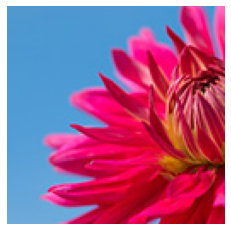

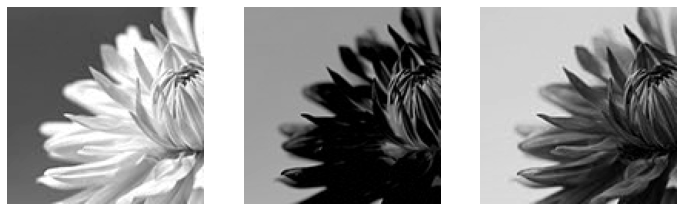

Conv2d(3, 5, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
pytorch input shape:  torch.Size([1, 3, 128, 128])
numpy input shape:  (1, 3, 130, 130)
output dimensions:  64 64


In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.transforms.functional import pad
import numpy as np
import time
import numpy.testing as npt
from PIL import Image 
from matplotlib import pyplot as plt

torch.manual_seed(1)

#### Load image and visualize its 3 channels ####
#### The image is available at the ./images folder within the repo ####
img = Image.open("flower128.jpg")  
plt.figure()
plt.axis('off')
plt.imshow(img)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.axis('off')
    plt.imshow(np.array(img)[:, :, i], cmap='gray', vmin = 0, vmax = 255)
plt.show()

#### Setup conv layer parameters ####
w_in=img.size[0]
h_in=img.size[1]
c_in=3
c_out=5
k=3
stride=2
padding=1
# (n+2*pad-ks)//stride +1
w_out = (w_in+2*padding-k)//stride +1
h_out = (h_in+2*padding-k)//stride +1

#### Setup Pytorch Conv2d layer ####
data = transforms.ToTensor()(img).unsqueeze_(0)

def init_weights(m):
  if isinstance(m, nn.Conv2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.normal_(m.bias, 0.0, 0.02)

convlayer=nn.Conv2d(c_in, c_out, k, stride=stride, padding=padding)
convlayer=convlayer.apply(init_weights)
print(convlayer)

#### Setup Numpy data ####
img2= img.copy()
img2=pad(img2, (1,1))
data2 = np.array(img2).transpose((2, 0, 1))
data2 = np.expand_dims(data2, axis=0)
data2 = data2/255.0

print("pytorch input shape: ",data.shape) 
print("numpy input shape: ",data2.shape) 
print("output dimensions: ",w_out, h_out) 


In [3]:
#### Setup Numpy weight and bias structures ####
print(convlayer.weight.shape)
print(convlayer.bias.shape)
w=np.zeros((c_out, c_in, k, k))
b=np.zeros((c_out))

#### Create 3 kernels ####
ker=[]
ker.append(np.array([[-1.1,-1.1,-1.1],[2.2,2.2,2.2],[-1.1,-1.1,-1.1]]))
ker.append(np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]))
ker.append(np.array([[0.0,-1.0,0.0],[-1.0,6.0,-1.0],[0.0,-1.0,0.0]]))

#### Hack the pytorch weights ####
with torch.no_grad():
  for w0 in range(convlayer.weight.shape[0]):
      for w1 in range(convlayer.weight.shape[1]):
          if (w0<len(ker)):
             convlayer.weight[w0][w1]=torch.from_numpy(ker[w0])

#### Hack the numpy weights ####
for w0 in range(c_out):
   for w1 in range(c_in):
      if (w0<len(ker)):
             w[w0][w1]=ker[w0]
      else: 
        w[w0][w1]=np.around(convlayer.weight[w0][w1].detach().numpy(),decimals=4) #np.random.normal(0, 0.02)
   b[w0]=np.around(convlayer.bias[w0].detach().numpy(),decimals=4)
   
#print(w)
print(convlayer.bias)
print(b)

torch.Size([5, 3, 3, 3])
torch.Size([5])
Parameter containing:
tensor([-0.0142,  0.0045, -0.0010, -0.0067,  0.0044], requires_grad=True)
[-0.0142  0.0045 -0.001  -0.0067  0.0044]


In [4]:
#### Create the python convolutional layer ####
def python_conv(data):
 res=np.zeros((1, c_out, w_out, h_out))  
 for o1 in range(w_out):
      for o2 in range(h_out):
             for co in range(c_out):
                    total=0
                    for ci in range(c_in):
                          kt=0
                          for k1 in range(k):
                                 for k2 in range(k):
                                        weight = w[co,ci,k1,k2]
                                        pos1=k1+o1*stride
                                        pos2=k2+o2*stride
                                        value = data[0, ci, pos1 ,pos2]
                                        kt+= weight * value
                          total+=kt
                    res[0,co,o1,o2]=total+b[co]
 return res

#### Create the sigmoid function to normalize the output to the 0-1 range ####
def sigm(data):
 z = 1/(1 + np.exp(-data))
 return z



In [5]:
#### Run the pytorch conv layer ####
start=time.time()
ptorch_out = convlayer(data)
ptorch_out = nn.Sigmoid()(ptorch_out)
end=time.time()
print("conv2d completed")
print("Pytorch: time taken: ",end-start)

#### Run the python-numpy conv layer ####
start=time.time()
numpy_out = python_conv(data2) 
numpy_out = sigm(numpy_out)
end=time.time()
print("Python: time taken: ",end-start)

#### Print and compare output shapes ####
print()
print("Pytorch in shape: ",data.shape)
print("Python in shape: ",data2.shape)
print("Pytorch out shape: ",ptorch_out.shape)
print("Python out shape: ",numpy_out.shape)
print("weight shape: ",convlayer.weight.shape)
print("bias shape: ",convlayer.bias.shape)
print()

#### Extract a fragment of the output to compare both outputs ####
pytorch_verify=ptorch_out[0][0][0].cpu().detach().numpy()
pytorch_verify=np.around(pytorch_verify,decimals=3)
numpy_verify=np.around(numpy_out[0][0][0],decimals=3)

print("pytorch: ",pytorch_verify[:25])
print("python: ",numpy_verify[:25])
assert np.allclose(pytorch_verify, numpy_verify)

conv2d completed
Pytorch: time taken:  0.06419754028320312
Python: time taken:  0.5630500316619873

Pytorch in shape:  torch.Size([1, 3, 128, 128])
Python in shape:  (1, 3, 130, 130)
Pytorch out shape:  torch.Size([1, 5, 64, 64])
Python out shape:  (1, 5, 64, 64)
weight shape:  torch.Size([5, 3, 3, 3])
bias shape:  torch.Size([5])

pytorch:  [0.978 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997
 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997
 0.997]
python:  [0.978 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997
 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997
 0.997]


<Figure size 1200x1200 with 0 Axes>

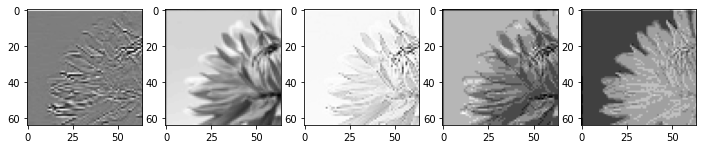

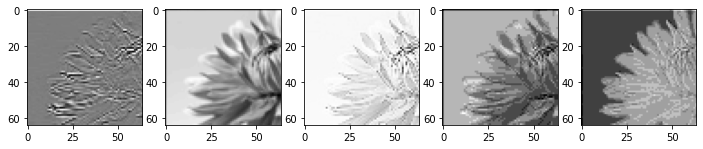

In [6]:
%matplotlib inline

#### Visualize the 5 output channels of both pytorch and python-numpy versions ####
nc=5
plt.figure(figsize=(15, 15), dpi=80)

fig, axs = plt.subplots(nrows=1, ncols=nc, figsize=(12,4))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    #plt.axis('off')
    im=transforms.ToPILImage(mode='L')(ptorch_out[0][i])
    plt.imshow(im, cmap='gray')
#plt.tight_layout()
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=nc, figsize=(12,4))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    #plt.axis('off')
    im = Image.fromarray(numpy_out[0][i]*255)
    im = im.convert("L")
    plt.imshow(im, cmap='gray')
plt.show()